In [31]:
import yfinance as yf
import pandas as pd

def pick_row(df: pd.DataFrame, preferred_names):
    """
    Return the first row label from preferred_names that exists in df.index.
    Raise KeyError if none are found.
    """
    for name in preferred_names:
        if name in df.index:
            return name
    raise KeyError(f"None of {preferred_names} found in DataFrame index.")


In [32]:
def compute_company_roi_series(ticker_symbol: str) -> pd.DataFrame:
    """
    Compute annual ROI = Net Income / Invested Capital
    for all years where both numbers are available.
    Returns a DataFrame with columns: net_income, invested_capital, roi.
    Index = year-end dates from Yahoo Finance.
    """
    ticker = yf.Ticker(ticker_symbol)

    income = ticker.financials
    balance = ticker.balance_sheet

    # Pick appropriate rows using robust helper
    net_income_row = pick_row(income, [
        "Net Income",  # this exists in your META data
        "Net Income From Continuing And Discontinued Operation",
    ])

    invested_capital_row = pick_row(balance, [
        "Invested Capital",  # this exists in your META balance sheet
    ])

    # Use only years that exist in BOTH statements
    common_cols = income.columns.intersection(balance.columns)

    if common_cols.empty:
        raise ValueError("No common years between income statement and balance sheet.")

    # Align the two series on the same columns
    net_income = income.loc[net_income_row, common_cols]
    invested_capital = balance.loc[invested_capital_row, common_cols]

    # Avoid division by zero
    invested_capital = invested_capital.replace(0, pd.NA)

    roi = net_income / invested_capital

    # Build a tidy DataFrame
    df_roi = pd.DataFrame({
        "net_income": net_income,
        "invested_capital": invested_capital,
        "roi": roi,  # this is in decimal form (e.g. 0.25 = 25%)
    })

    # Sort by date ascending for readability
    df_roi = df_roi.sort_index()

    return df_roi




In [33]:
# Example usage:
ticker = 'META'
meta_roi = compute_company_roi_series(ticker)
print(meta_roi)
print("\nROI as percentage:")
print((meta_roi["roi"] * 100).round(2).astype(str) + " %")

              net_income  invested_capital       roi
2020-12-31           NaN               NaN       NaN
2021-12-31  3.937000e+10      1.248790e+11  0.315265
2022-12-31  2.320000e+10      1.356360e+11  0.171046
2023-12-31  3.909800e+10      1.715530e+11  0.227906
2024-12-31  6.236000e+10      2.114630e+11  0.294898

ROI as percentage:
2020-12-31      nan %
2021-12-31    31.53 %
2022-12-31     17.1 %
2023-12-31    22.79 %
2024-12-31    29.49 %
Name: roi, dtype: object


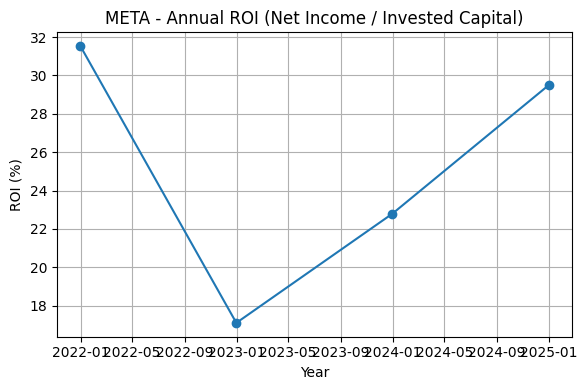

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))

# Plot ROI in percentage
plt.plot(meta_roi.index, meta_roi["roi"] * 100, marker="o")

plt.title(ticker + " - Annual ROI (Net Income / Invested Capital)")
plt.xlabel("Year")
plt.ylabel("ROI (%)")
plt.grid(True)

plt.tight_layout()
plt.show()